In [1]:
from SPUD_and_MASH import MASH, SPUD
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
import matplotlib.pyplot as plt

2024-09-28 18:15:44.956156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 18:15:44.957880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 18:15:44.961551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 18:15:44.972212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 18:15:44.989626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# KEMA Tests 

In [2]:
#This is a long import -> 4 seconds. Starting the engine takes 18 seconds
import matlab.engine
import test_manifold_algorithms as tma
eng = matlab.engine.start_matlab()
eng.cd(r'/yunity/arusty/Graph-Manifold-Alignment/KEMA/general_routine', nargout=0)

RuntimeError: Could not find directory: /usr/local/MATLAB/R2024a/extern/engines/python/dist/matlab/engine/glnxa64

In [35]:
# Convert to MATLAB types
dc0 = tma.test_manifold_algorithms(csv_file="mnist_test.csv", split = "distort", percent_of_anchors= [0.2], verbose = 4, random_state= 12345)

dc0.split_A = dc0.split_A[:1000]
dc0.split_B = dc0.split_B[:1000]
dc0.labels = dc0.labels[:1000]

print("\n")
labeled = [
    {'X': matlab.double((dc0.split_A.T).tolist()), 'Y': matlab.double(dc0.labels.reshape(-1, 1).tolist())}, # It needs this shape to be transposed....
    {'X': matlab.double((dc0.split_B.T).tolist()), 'Y': matlab.double(dc0.labels.reshape(-1, 1).tolist())}
]

unlabeled = [
    {'X': matlab.double([])},
    {'X': matlab.double([])}
]

ALPHA, LAMBDA, options = eng.KMA(labeled, unlabeled,  {"kernelt" : 'lin', "debug" : 1}, nargout = 3, background = False)


 
 
---------------------------       Initalizing class with mnist_test.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (10000, 784)
Split B Features shape (10000, 784)
MDS initialized with 784 components
The knn values are: (2, 203, 404, 605, 806, 1007, 1208, 1409, 1610, 1811)


Setting 4 NN by default
Setting mu=0.5 by default
Displaying X1: 
         784        1000

Displaying Y size: 
        2000           1

Solve eigenproblem
Check for vector inversion
... done.


In [36]:
# 3) project test data

# Convert to MATLAB types
test = [
    {'X': matlab.double((dc0.split_A.T).tolist())},
    {'X': matlab.double((dc0.split_B.T).tolist())}
]

save_files = 1

emb = eng.Adam_MATLAB(labeled,unlabeled,test,ALPHA,options, save_files, dc0.n_comp, nargout = 1, background = False )

YT1
   500     1

Y1
        1000           1

Phi1TtoF(1,:)
           1        1000

File Saved
File Saved
Final N_comp: 
   784



Embedding shape (2, 784, 1000)


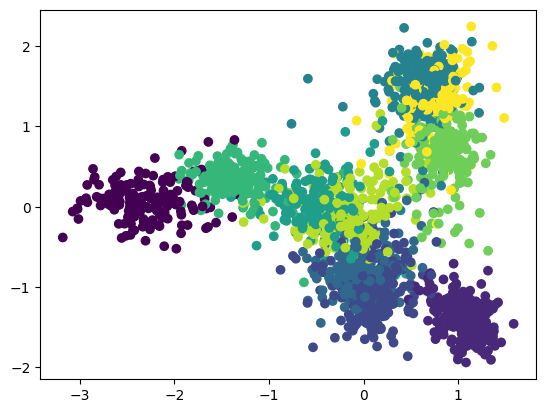

In [38]:
import seaborn as sns
from pandas import Categorical
import matplotlib.pyplot as plt
import numpy as np
emb = np.array(emb)
print(f"Embedding shape {emb.shape}")
plt.scatter(x = emb[:, 0], y = emb[:, 1],  c = np.concatenate([dc0.labels, dc0.labels]), cmap = 'viridis')

In [39]:
import numpy as np

emb = np.array(emb)

# Get the middle dimension
middle_dim = emb.shape[1]

# Flatten the array while preserving the structure
emb = emb.transpose(1, 0, 2).reshape(middle_dim, -1).T

In [40]:
emb.shape

(2000, 784)

<Axes: >

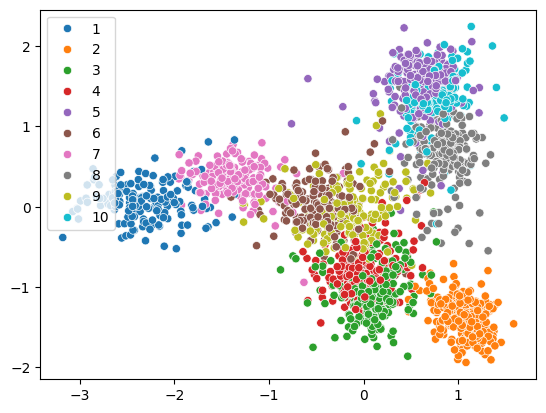

In [41]:
import seaborn as sns
from pandas import Categorical
sns.scatterplot(x = emb[:, 0], y = emb[:, 1], hue = Categorical(np.concatenate([dc0.labels, dc0.labels])))

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from scipy.spatial.distance import pdist, squareform

def cross_embedding_knn(embedding, Labels, knn_args = {'n_neighbors': 4}):
        """
        Returns the classification score by training on one domain and predicting on the the other.
        This will test on both domains, and return the average score.
        
        Parameters:
            :embedding: the manifold alignment embedding. 
            :Labels: a concatenated list of labels for domain A and labels for domain B
            :knn_args: the key word arguments for the KNeighborsClassifier."""

        (labels1, labels2) = Labels

        n1 = len(labels1)

        #initialize the model
        knn = KNeighborsClassifier(**knn_args)

        #Fit and score predicting from domain A to domain B
        knn.fit(embedding[:n1, :], labels1)
        score1 =  knn.score(embedding[n1:, :], labels2)

        #Fit and score predicting from domain B to domain A, and then return the average value
        knn.fit(embedding[n1:, :], labels2)
        return np.mean([score1, knn.score(embedding[:n1, :], labels1)])

#Adam added this functions -> it helps create the FOSCTTM Metric
def SquareDist(domain_A):
    #Just using a normal distance matrix without Igraph
    x_dists = squareform(pdist(domain_A))

    #normalize it
    x_dists = x_dists / np.max(x_dists, axis = None)

    return x_dists

In [ ]:
cross_embedding_knn(emb, (dc0.labels, dc0.labels))

0.8885448916408669

In [ ]:
block = SquareDist(emb)

block.shape

(646, 646)

In [ ]:
#Calculate FOSCTTM by averaging the two domains
len_A = len(dc0.split_A)
dc0.FOSCTTM(block[:len_A, len_A:])

0.23309913830286882

# Testing With MASH

## General Tests

In [3]:
from SPUD_and_MASH import MASH
import test_manifold_algorithms as tma

dcG = tma.test_manifold_algorithms(csv_file="iris.csv", split = "even", percent_of_anchors= [0.2], verbose = 1, random_state= 42)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------



In [5]:
mclass = MASH(t = 10, knn = 5, distance_measure_A="euclidean",  distance_measure_B="euclidean", DTM = "log", verbose = 1)
mclass.fit(dcG.split_A, dcG.split_B, dcG.anchors[:15])

Fit process finished. We recommend calling optimize_by_creating_connections.


In [6]:
mclass.optimize_by_creating_connections(epochs = 1000, connection_limit=None, hold_out_anchors=dcG.anchors[7:15])

Edges wont be set with similarity measure above: 0.49999996593497364


False

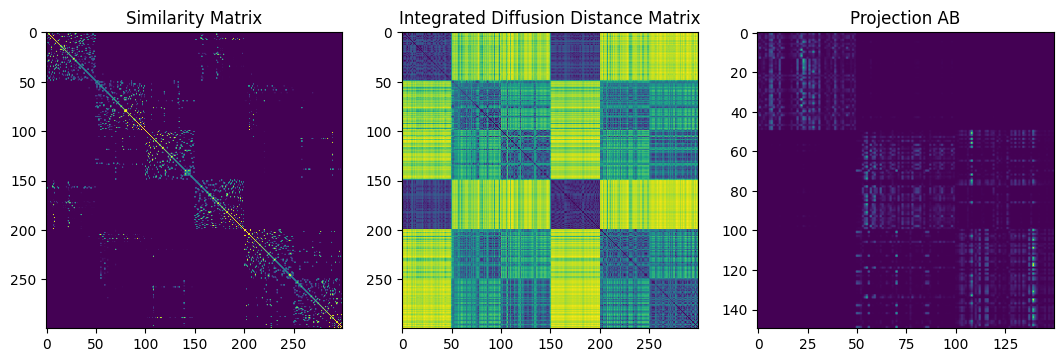

In [7]:
mclass.plot_heat_maps()

Cross Embedding score: 0.8933333333333333
Fraction of Samples Closest to thier Match: 0.16564444444444443


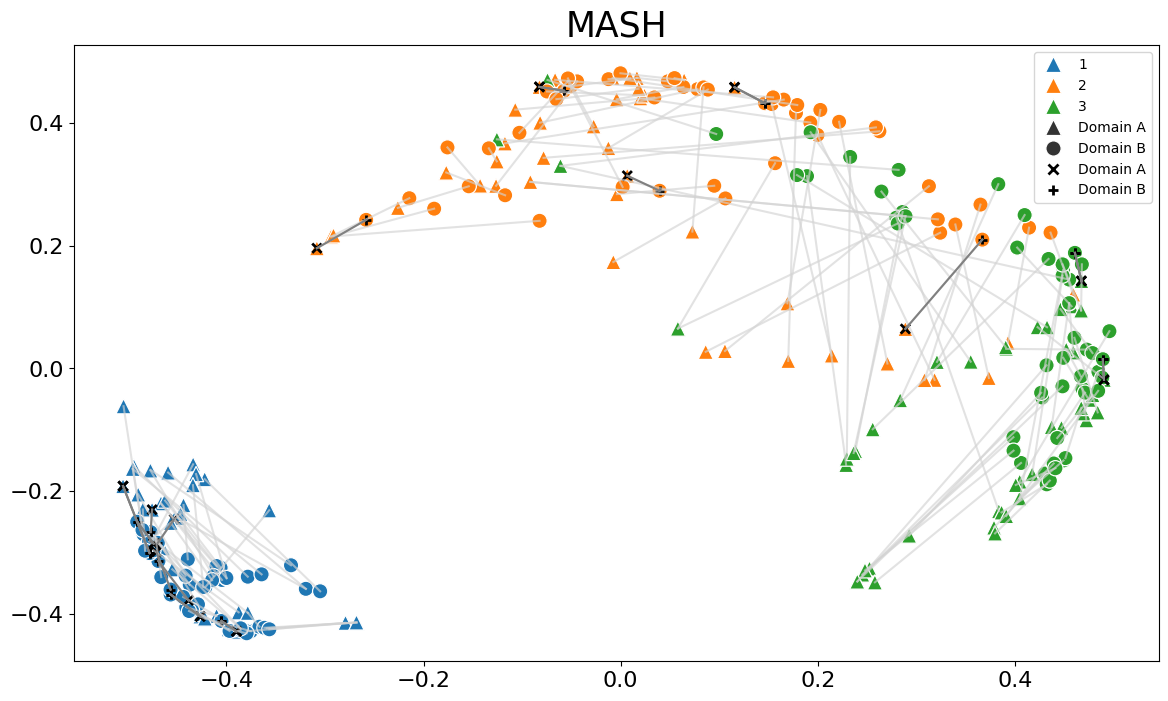

In [8]:
mclass.plot_emb(labels = dcG.labels_doubled, n_comp = 5)

## Time Tests

In [9]:
import test_manifold_algorithms as tma
from SPUD_and_MASH import MASH

dc3 = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)

MDS initialized with 4 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [10]:
mclass = MASH(t = -1, knn = 5, distance_measure_A="default",  distance_measure_B="euclidean", DTM = "log", verbose = 4)
mclass.fit(dc3.split_A, dc3.split_B, dc3.anchors[:15])

Time Data Below
 Time it took to execute the graph for domain A:  0.0941
 Time it took to compute kernal A:  0.00014
 Time it took to execute SGDM for domain B:  0.00063
 Time it took to execute the graph for domain B:  0.08918
 Time it took to compute merge_graphs function:  0.03562
 Time it took to compute similarity_matrix function:  0.00065
Using optimal t value of 21
 Time it took to compute diffusion process:  0.05074
Fit process finished. We recommend calling optimize_by_creating_connections.


# Testing With SPUD

In [2]:
import test_manifold_algorithms as tma
from SPUD_and_MASH import SPUD

dc3 = tma.test_manifold_algorithms(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 2, random_state= 42)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


## General SPUD tests

Notes about Absolute Value:
1. It seems to really like the "log" aggregation function, and does well with Nama. 
Try this code below:
sclass = SPUD(knn = 5, OD_method="abs", agg_method= "log", distance_measure_A="euclidean", distance_measure_B="euclidean", similarity_measure="nama", use_kernals=False, verbose = 4)
sclass.fit(dc3.split_A, dc3.split_B, dc3.anchors[:3])

In [3]:
import numpy
dc3.split_A[12:30, 2] = numpy.NaN
dc3.split_B[90:, [1,3]] = numpy.NaN
dc3.split_A[45:, 0] = numpy.NaN
dc3.split_B[:55, 1] = numpy.NaN

# dc3.split_A[12:30, 2] = -4
# dc3.split_B[90:, [1,3]] = -4
# dc3.split_A[45:, 0] = -4
# dc3.split_B[:55, 1] = -4

Preforming mean calculations.

<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>
Cross Embedding score: 0.78
Fraction of Samples Closest to thier Match: 0.0004888888888888889


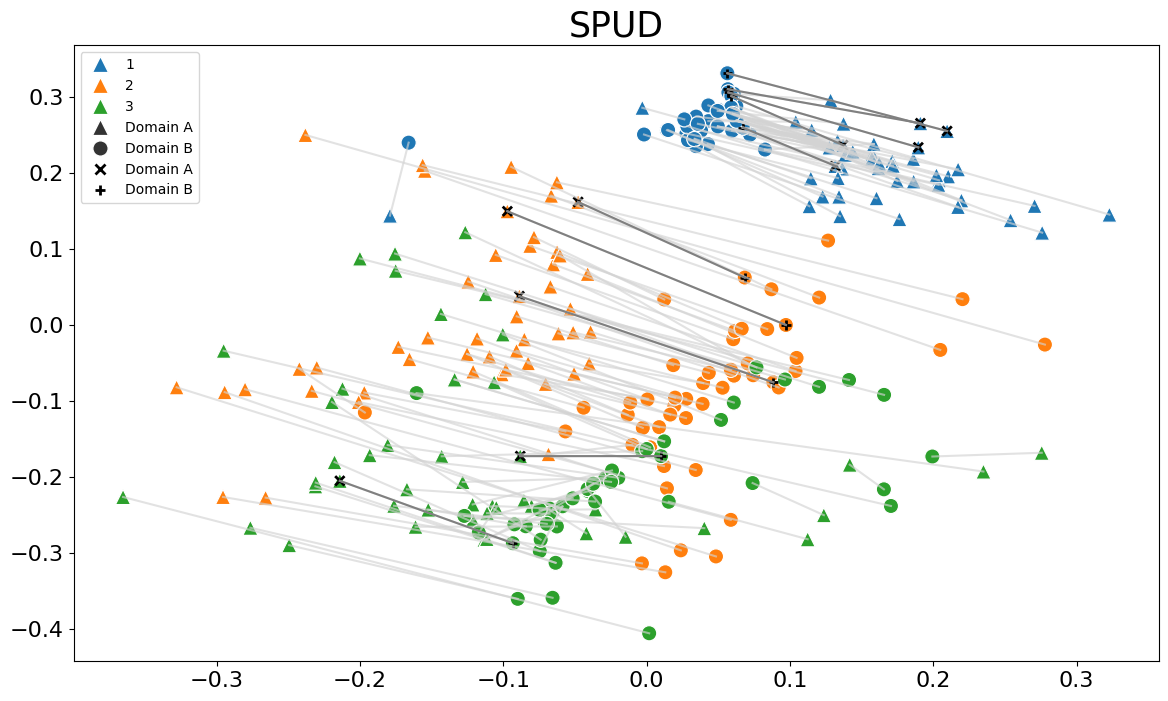

In [6]:
sclass = SPUD(knn = 57, OD_method="mean", agg_method= "log", overide_method="none", verbose = 3)
sclass.fit(dc3.split_A, dc3.split_B, dc3.anchors[:10])
sclass.plot_emb(dc3.labels_doubled, show_lines = True, show_anchors = True, show_legend = False, n_comp = 2)

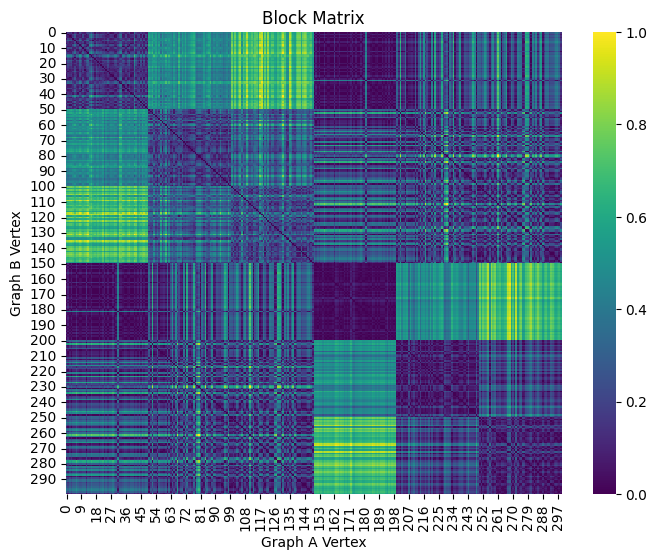

In [7]:
sclass.plot_heat_map()

## Time Tests

In [7]:
dc4 = tma.test_manifold_algorithms(csv_file="optdigits.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)
sclass = SPUD(knn = 5, OD_method= "abs", agg_method = "normalize", overide_method="nama", verbose = 4)
sclass.fit(dc4.split_A, dc4.split_B, dc4.anchors[:15])
#sclass.plot_emb(dc3.labels_doubled, show_lines = False, show_anchors = False, show_legend = False)

MDS initialized with 64 components

 
 
---------------------------       Initalizing class with optdigits.csv data       ---------------------------

The knn values are: (2, 79, 156, 233, 310, 387, 464, 541, 618, 695)


Time it took to compute SGDM:  1.99
Skipping graph creating. Performing nearest anchor manifold alignment (NAMA) instead of SPUD.
Preforming abs calculations.



KeyboardInterrupt: 

In [7]:
#Create a results table
import pandas as pd
spud_time_df = pd.DataFrame(           columns = ["CSV File", "Feature Shape",  "Anchor Count", "KNN", "SGDM Time", "Graph Time", "Merge Time", "Get Block Time"],
                    data = [[       "optdigits",    (3823, 41),          1500,        2,     1.11,       23.78,       0.01,         29.92 ],
                                    ["optidigits",  (3823, 41),           1500,        500,   1.25,       38.24,     2.37,          1296.43],
                                    ["optidigits",  (3823, 64),           15,           5,    1.38,             25.17,         0.02,          33.32],
    ["optidigits - OD_Method = abs without kernal",  (3823, 64),           15,           5,    2.05,             0.00,         0.00,          1.45],
                                    ["chess",          (3196, 36),        1500,        500,      0.78,         21.51,         1.65,           674.48 ],
                                    ["chess",          (3196, 36),        15,        500,      0.65,         20.33,         1.73,           682.11 ],
                                    ["chess",          (3196, 36),        15,        5,      0.63,         15.47,         0.01,             20.07 ],
                                    ["Waveform",     (5000, 40),         15,        5,        1.92,           58.67,       0.02,               67.54 ],
                                    ["Waveform",     (5000, 40),         1500,        1000,        1.90,     90.78,       6.51,         4924.34],
["Waveform - OD_method = mean with Kernals",     (5000, 40),         1500,        1000,        3.09,       91.16,      0.00,            2.84], #WOW! Look at this craxy time reduction!!!!
["Waveform - OD_method = mean without Kernals",     (5000, 40),         1500,        1000,        3.17,       0.00,      0.00,            2.89], #WOW! Look at this craxy time reduction!!!!
["Waveform - OD_method = mean with shortest path",     (5000, 40),         1500,        1000,        3.16,       89.98,      0.00,            3746.4],

                                    ["Iris",     (150, 4),               150,        148,        0,            0.16,       0.01,         0.18],
                  ["Iris - OD_method = abs without kernals",     (150, 4),               150,        148,        0,            0.0,       0.00,         0.01]])

spud_time_df['Total Time'] = spud_time_df['SGDM Time'] + spud_time_df['Graph Time'] + spud_time_df['Merge Time'] + spud_time_df['Get Block Time']
spud_time_df.sort_values(by='Total Time', inplace = True)

spud_time_df

,CSV File,Feature Shape,Anchor Count,KNN,SGDM Time,Graph Time,Merge Time,Get Block Time,Total Time
13,Iris - OD_method = abs without kernals,"(150, 4)",150,148,0.00,0.00,0.00,0.01,0.01
12,Iris,"(150, 4)",150,148,0.00,0.16,0.01,0.18,0.35
3,optidigits - OD_Method = abs without kernal,"(3823, 64)",15,5,2.05,0.00,0.00,1.45,3.50
10,Waveform - OD_method = mean without Kernals,"(5000, 40)",1500,1000,3.17,0.00,0.00,2.89,6.06
6,chess,"(3196, 36)",15,5,0.63,15.47,0.01,20.07,36.18
0,optdigits,"(3823, 41)",1500,2,1.11,23.78,0.01,29.92,54.82
2,optidigits,"(3823, 64)",15,5,1.38,25.17,0.02,33.32,59.89
9,Waveform - OD_method = mean with Kernals,"(5000, 40)",1500,1000,3.09,91.16,0.00,2.84,97.09
7,Waveform,"(5000, 40)",15,5,1.92,58.67,0.02,67.54,128.15
4,chess,"(3196, 36)",1500,500,0.78,21.51,1.65,674.48,698.42


# Sparse Data Tests

In [8]:
import numpy as np
sparse_dc = tma.test_manifold_algorithms(csv_file="Cancer_Data.csv", split= "skewed", percent_of_anchors= [0.8], verbose=2, random_state=25)
sparse_dc.split_A = sparse_dc.split_A
sparse_dc.split_B = sparse_dc.split_B
#Randomly select points
import random
random_points = random.sample(range(len(sparse_dc.split_A)), k = int(len(sparse_dc.split_A)/10))

#Create the macthing anchors
sparse_dc.anchors = np.array([range(int(len(sparse_dc.split_A)/10)), random_points]).T

#Subset split A to only have some of the points
sparse_dc.split_A = sparse_dc.split_A[random_points]

#Create labels
sparse_labels = np.hstack([sparse_dc.labels[random_points], sparse_dc.labels])

MDS initialized with 15 components

 
 
---------------------------       Initalizing class with Cancer_Data.csv data       ---------------------------

The knn values are: (2, 14, 26, 38, 50, 62, 74, 86, 98, 110)


In [18]:
sclass = SPUD(knn = 10, OD_method= "mean", agg_method = "sqrt", verbose = 3, random_state = 10)
sclass.fit(sparse_dc.split_A, sparse_dc.split_B, sparse_dc.anchors)

/yunity/arusty/Graph-Manifold-Alignment/.venv/lib/python3.10/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (569, 569) is expensive. Consider setting n_pca.
  warnings.warn(


Preforming mean calculations.

<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


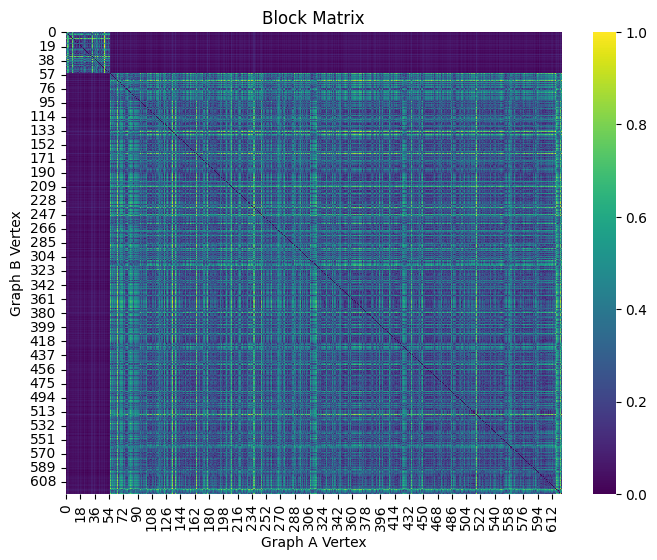

In [19]:
sclass.plot_heat_map()

Cross Embedding score: 0.8256496359527994
Fraction of Samples Closest to thier Match: None


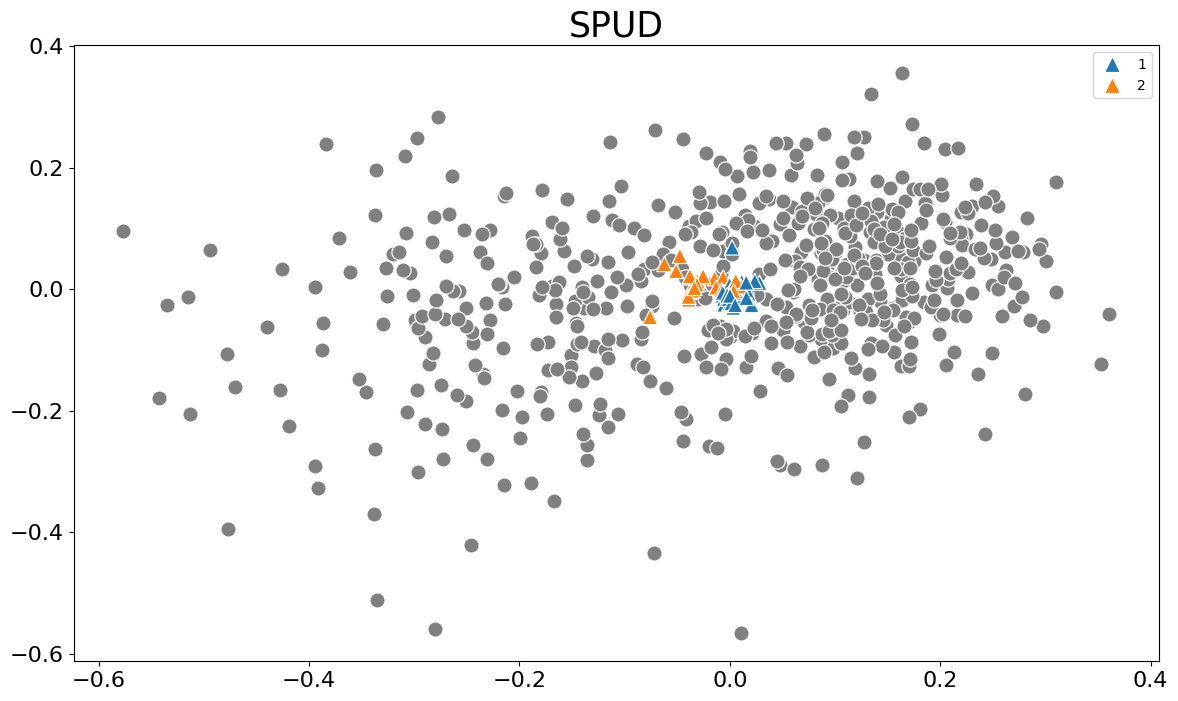

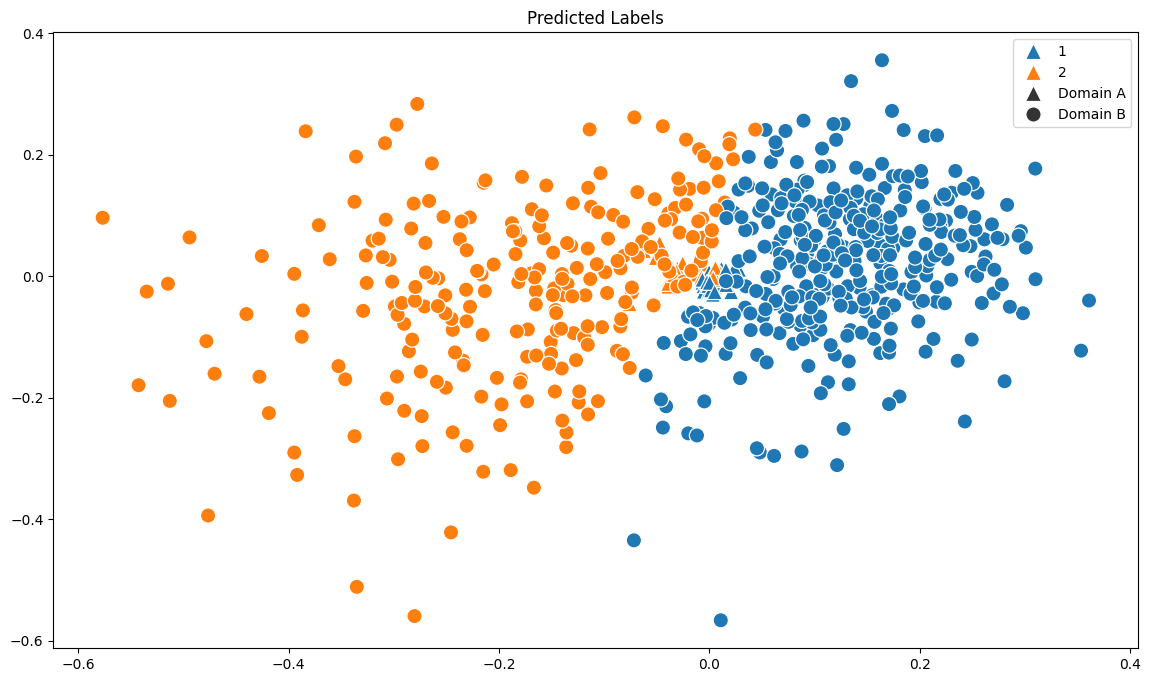

In [20]:
sclass.plot_emb(sparse_labels, show_lines = False, show_anchors = False, show_pred= True)

Time Data Below
 Time it took to execute the graph for domain A:  0.04756
 Time it took to compute kernal A:  2e-05
 Time it took to execute the graph for domain B:  0.07469
 Time it took to compute kernal B:  0.00043
 Time it took to compute merge_graphs function:  0.13149
 Time it took to compute similarity_matrix function:  0.00215
Using optimal t value of 9
 Time it took to compute diffusion process:  0.25119
Fit process finished. We recommend calling optimize_by_creating_connections.
Time it took to calculate the embedding: 2.92133
Cross Embedding score: 0.9326512678885263
Fraction of Samples Closest to thier Match: None


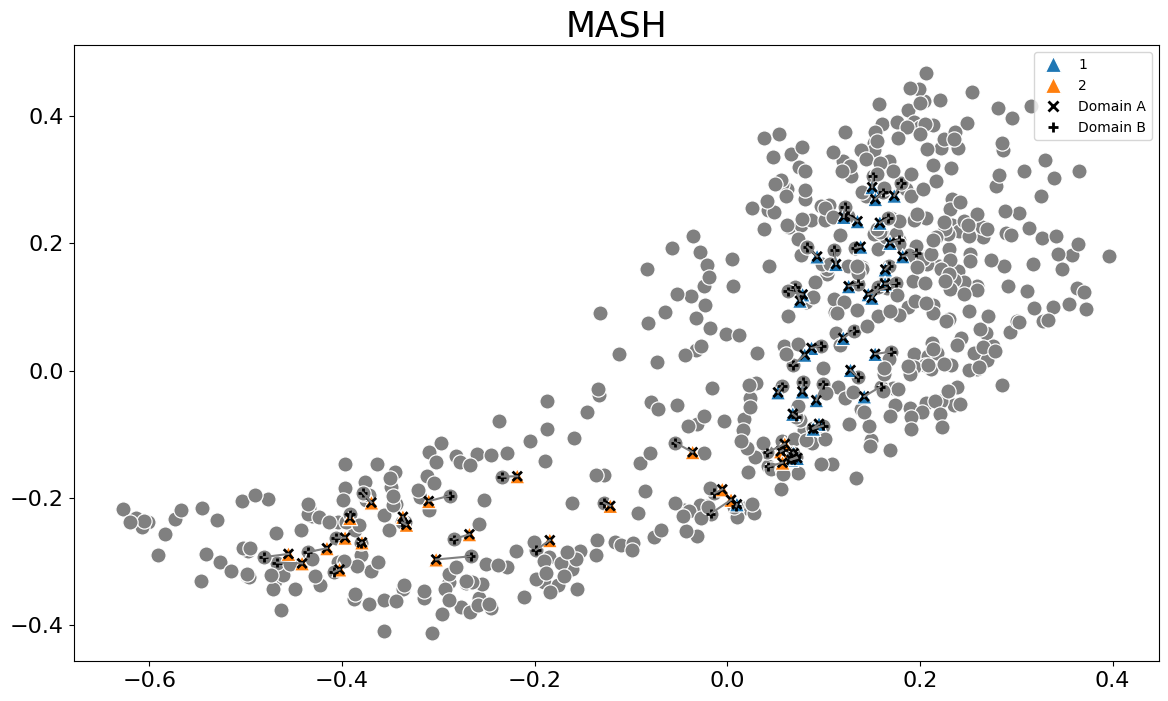

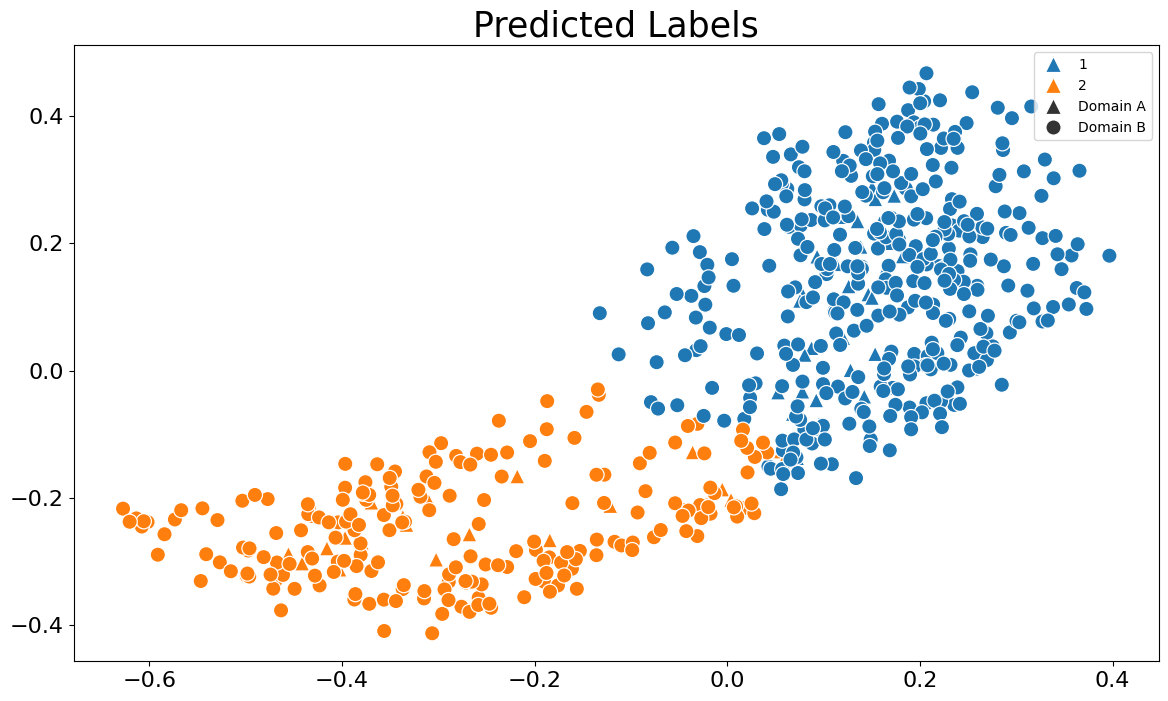

In [13]:
dclass = MASH(knn = 8, DTM = "log", verbose = 3)
dclass.fit(sparse_dc.split_A, sparse_dc.split_B, sparse_dc.anchors)
dclass.plot_emb(sparse_labels, show_lines = False, show_pred = True, show_legend = False, n_comp = 4)

In [14]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

pca = PCA(n_components=min(len(sparse_dc.split_A[1]), len(sparse_dc.split_B[1])))
A_emb = pca.fit_transform(sparse_dc.split_A)
B_emb = pca.fit_transform(sparse_dc.split_B)

#Initilize model
model = KNeighborsClassifier(n_neighbors = 8)


#Split data and train for split A

model.fit(A_emb, sparse_dc.labels[random_points])
print(f"    Classification Score trained on A {model.score(B_emb, sparse_dc.labels)}")

#Split data and train for split B
try:
    model.fit(B_emb, sparse_dc.labels)
    print(f"    Classification Score trained on B {model.score(A_emb, sparse_dc.labels[random_points])}")
except:
    print(f"    Classification Score trained on B Failed")

    Classification Score trained on A 0.9015817223198594
    Classification Score trained on B 0.8571428571428571


# RF Base Line Tests

In [15]:
import test_manifold_algorithms as tma

dcRF = tma.test_manifold_algorithms(csv_file="Cancer_Data.csv", split = "random", percent_of_anchors= [0.2], verbose = 1, random_state= 42)


 
 
---------------------------       Initalizing class with Cancer_Data.csv data       ---------------------------



In [16]:
from rfgap import RFGAP
import seaborn as sns


def run_RF_BL_tests(self):
        """Needs no additional paramenters.
        
        Gets the baseline classification without doing any alignment for each data set"""

        
        """Editing here"""
        #Initilize Class
        rf_class = RFGAP(prediction_type="classification", y=self.labels, prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

        #Fit it for Data A and get proximities
        rf_class.fit(self.split_A, y = self.labels)
        dataA = rf_class.get_proximities()
        if np.max(dataA[~np.isinf(dataA)]) != 0:
            dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 
        dataA[np.isinf(dataA)] = 1
        dataA = 1 - dataA

        #Fit it for Data B and get proximities
        rf_class.fit(self.split_B, y = self.labels)
        dataB = rf_class.get_proximities()
        if np.max(dataB[~np.isinf(dataB)]) != 0:
            dataB = (dataB - dataB.min()) / (dataB[~np.isinf(dataB)].max() - dataB.min()) 
        dataB[np.isinf(dataB)] = 1
        dataB = 1 - dataB

        #create squares
        from scipy.spatial.distance import pdist, squareform
        distsA = squareform(pdist(dataA))
        distsB = squareform(pdist(dataB))

        #Get cross embedding score
        A_emb = self.mds.fit_transform(np.block([[distsA, dataA],
                                                [dataA.T, distsA]]))
        B_emb = self.mds.fit_transform(np.block([[distsB, dataB],
                                                [dataB.T, distsB]]))

                 
        #Create an array to store the important data in 
        scores = np.zeros(2) #Now both of these are classification scores -- one for Split A and one for Split B

        print("\n--------------------------------------   RF Gap Baseline Tests " + self.base_directory[53:-1] + "   --------------------------------------\n")
            
        #Run CE and FOSCTTM
        scores[0] = np.mean((self.FOSCTTM(dataA), self.FOSCTTM(dataB)))
        scores[1] = np.mean((self.cross_embedding_knn(A_emb, (self.labels, self.labels), other_side = True), self.cross_embedding_knn(B_emb, (self.labels, self.labels), other_side = False)))

        print(f"FOSCTTM SCORE: {scores[0]}")
        print(f"CE SCORE: {scores[1]}")


        #Run successful
        return A_emb


In [17]:
emb1 = run_RF_BL_tests(dcRF)

KeyboardInterrupt: 

<Axes: >

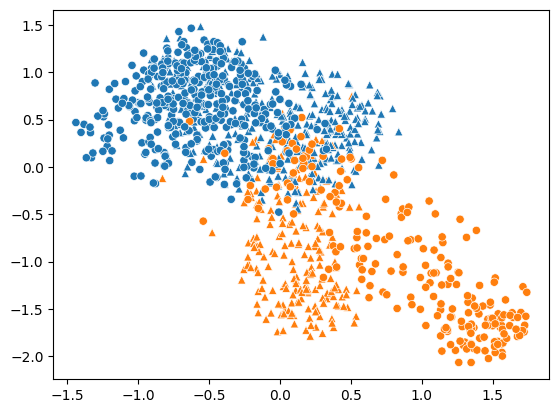

In [17]:
#plot the data
styles = ['triangle' if i < len(emb1[:]) / 2 else 'circle' for i in range(len(emb1[:]))]

#SNS plotting
sns.scatterplot(legend = False, x = emb1[:, 0], y = emb1[:, 1], hue = pd.Categorical(dcRF.labels_doubled), style = styles, markers= {"triangle": "^", "circle" : "o"})

In [18]:
from rfgap import RFGAP
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors



def run_RF_BL_tests2(self):
        """Needs no additional paramenters.
        
        Gets the baseline classification without doing any alignment for each data set"""

        
        """Editing here"""
        #Initilize Class
        rf_class = RFGAP(prediction_type="classification", y=self.labels, prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

        #Fit it for Data A and get proximities
        rf_class.fit(self.split_A, y = self.labels)
        dataA = rf_class.get_proximities()
        if np.max(dataA[~np.isinf(dataA)]) != 0:
            dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 
        dataA[np.isinf(dataA)] = 1
        dataA = 1 - dataA

        #Fit it for Data B and get proximities
        rf_class.fit(self.split_B, y = self.labels)
        dataB = rf_class.get_proximities()
        if np.max(dataB[~np.isinf(dataB)]) != 0:
            dataB = (dataB - dataB.min()) / (dataB[~np.isinf(dataB)].max() - dataB.min()) 
        dataB[np.isinf(dataB)] = 1
        dataB = 1 - dataB

        #create squares
        from scipy.spatial.distance import pdist, squareform
        distsA = squareform(pdist(dataA))
        distsB = squareform(pdist(dataB))

        #Get cross embedding score
        A_emb = self.mds.fit_transform(distsA)
        B_emb = self.mds.fit_transform(distsB)

                 
        #Create an array to store the important data in 
        scores = np.zeros(2) #Now both of these are classification scores -- one for Split A and one for Split B

        print("\n--------------------------------------   RF Gap Baseline Tests " + self.base_directory[53:-1] + "   --------------------------------------\n")
        

        X_train, X_test, y_train, y_test = train_test_split(A_emb, self.labels, test_size=0.5, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=4)
        knn.fit(X_train, y_train)
        ce_score_A =  knn.score(X_test, y_test)

        X_train, X_test, y_train, y_test = train_test_split(B_emb, self.labels, test_size=0.5, random_state=42)
        knn.fit(X_train, y_train)
        ce_score_B =  knn.score(X_test, y_test)
        
        #Run CE and FOSCTTM
        scores[0] = np.mean((self.FOSCTTM(dataA), self.FOSCTTM(dataB)))
        scores[1] = np.mean((ce_score_A, ce_score_B))

        print(f"FOSCTTM SCORE: {scores[0]}")
        print(f"CE SCORE: {scores[1]}")


        #Run successful
        return A_emb



--------------------------------------   RF Gap Baseline Tests Cancer_Data   --------------------------------------

FOSCTTM SCORE: 0.0
CE SCORE: 0.968421052631579


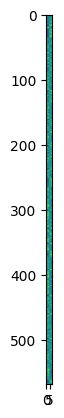

In [19]:
emb2 = run_RF_BL_tests2(dcRF)
plt.imshow(emb2)

<Axes: >

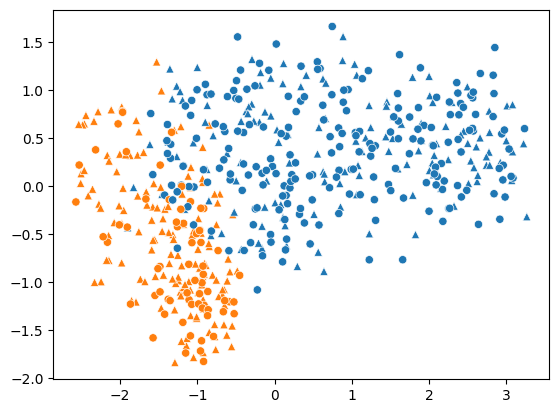

In [20]:
#plot the data
styles = ['triangle' if i < len(emb2[:]) / 2 else 'circle' for i in range(len(emb2[:]))]

#SNS plotting
sns.scatterplot(legend = False, x = emb2[:, 0], y = emb2[:, 1], hue = pd.Categorical(dcRF.labels), style = styles, markers= {"triangle": "^", "circle" : "o"})